**GenDF Backend Code** | *Kavini Fernando*

# Baseline Model: Plain EfficientNet-B0 (No RL, No CL, No TTT)
This notebook trains a plain EfficientNet-B0 on the original Real vs Fake dataset.  
It serves as a baseline for benchmarking GenDF versions A, B, and C.

 STEP 1: Setup and Imports

In [ ]:
# Install dependencies
!pip install -q torch torchvision gdown

# Imports
import os
import zipfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.8 MB/s eta 0:00:00
Device: cpu


STEP 2: Download and Prepare Dataset

In [ ]:
import gdown

# Download and extract dataset
gdown.download("https://drive.google.com/uc?id=1RZ2MXgM_6ehgMYOFhjBQHMJO1ZdgiEnG", "Real_and_Fake_Dataset.zip", quiet=False)
with zipfile.ZipFile("Real_and_Fake_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("./Real_and_Fake_Dataset")
os.remove("Real_and_Fake_Dataset.zip")

# Basic preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

full_dataset = ImageFolder(root="./Real_and_Fake_Dataset/real_and_fake_face", transform=transform)

# Split
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")


Downloading...
From (original): https://drive.google.com/uc?id=1RZ2MXgM_6ehgMYOFhjBQHMJO1ZdgiEnG
From (redirected): https://drive.google.com/uc?id=1RZ2MXgM_6ehgMYOFhjBQHMJO1ZdgiEnG&confirm=t&uuid=4abac297-fd7f-4d25-bff5-858c22711871
To: /content/Real_and_Fake_Dataset.zip
100%|██████████| 452M/452M [00:07<00:00, 59.7MB/s]


Train: 1428 | Val: 306 | Test: 307


STEP 3: Define and Train Baseline Model

In [ ]:
# Define model
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

# Training loop
train_losses, val_losses = [], []

for epoch in range(5):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 53.6MB/s]


Epoch 1: Train Loss = 0.6519, Val Loss = 0.5708
Epoch 2: Train Loss = 0.3855, Val Loss = 0.5382
Epoch 3: Train Loss = 0.1887, Val Loss = 0.5394
Epoch 4: Train Loss = 0.0971, Val Loss = 0.5888
Epoch 5: Train Loss = 0.0735, Val Loss = 0.6078


STEP 4: Evaluate Performance (Model Testing)


Evaluation Metrics:
Accuracy : 0.7777777777777778
F1 Score : 0.7926829268292683
Precision: 0.8125
Recall   : 0.7738095238095238
Confusion Matrix:
 [[108  30]
 [ 38 130]]


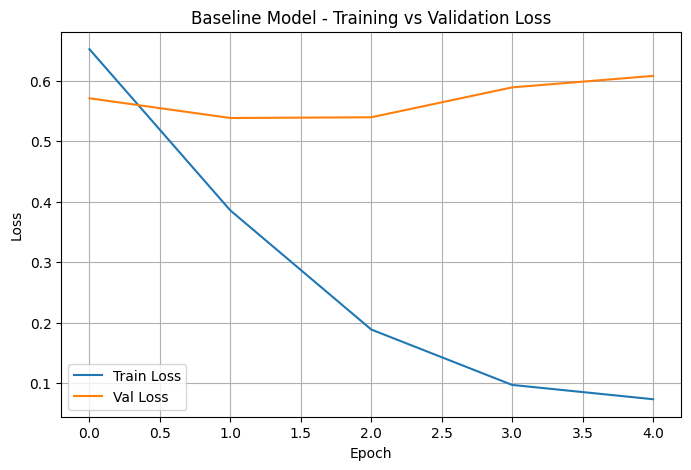

AUC Score: 0.861456176673568


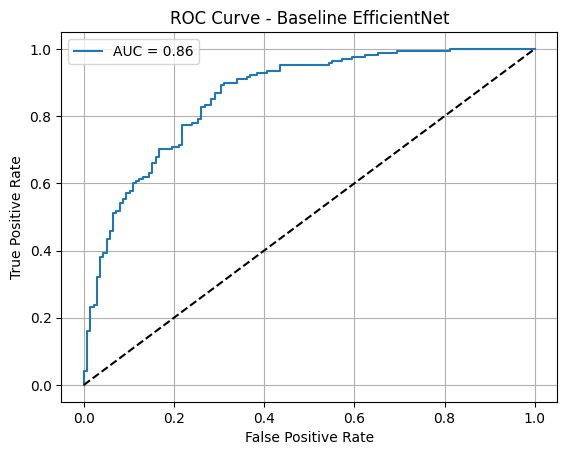

In [ ]:
# Inference on validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("\nEvaluation Metrics:")
print("Accuracy :", accuracy_score(all_labels, all_preds))
print("F1 Score :", f1_score(all_labels, all_preds))
print("Precision:", precision_score(all_labels, all_preds))
print("Recall   :", recall_score(all_labels, all_preds))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

# Plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Baseline Model - Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


# ROC + AUC
with torch.no_grad():
    all_probs = []
    for images, _ in val_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs[:, 1])  # Probability of class 1 ("Fake")

auc = roc_auc_score(all_labels, all_probs)
print("AUC Score:", auc)

fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Baseline EfficientNet")
plt.legend()
plt.grid(True)
plt.show()


STEP 5: Save the Baseline Model

In [ ]:
torch.save(model, "gendf_baseline.pth")
print("✅ Baseline model saved as gendf_baseline.pth")


✅ Baseline model saved as gendf_baseline.pth
